In [2]:
import os
import pandas as pd
adult_filename = os.path.join(os.path.curdir, "adult.data")

In [3]:
adult = pd.read_csv(
    adult_filename,
    header=None,
    names=[
        "Age", "Work-Class", "fnlwgt", "Education",
        "Education-Num", "Marital-Status", "Occupation",
        "Relationship", "Race", "Sex", "Capital-gain",
        "Capital-loss", "Hours-per-week", "Native-Country",
        "Earnings-Raw"
    ]
)

In [4]:
adult.dropna(how='all', inplace=True)

In [5]:
adult.head()

,Age,Work-Class,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-Country,Earnings-Raw
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

In [7]:
adult["Hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours-per-week, dtype: float64

In [8]:
adult["Education-Num"].median()

10.0

In [9]:
adult["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'], dtype=object)

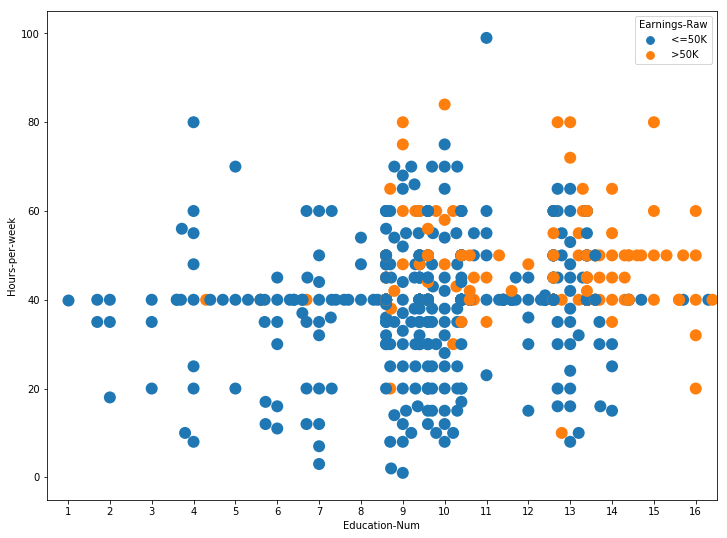

In [11]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 9))
sns.swarmplot(x="Education-Num", y="Hours-per-week", hue="Earnings-Raw", data=adult[::50], size=12)

In [12]:
import numpy as np
X = np.arange(30).reshape((10, 3))

In [13]:
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29]])

In [14]:
X[:,1] = 1

In [15]:
X

array([[ 0,  1,  2],
       [ 3,  1,  5],
       [ 6,  1,  8],
       [ 9,  1, 11],
       [12,  1, 14],
       [15,  1, 17],
       [18,  1, 20],
       [21,  1, 23],
       [24,  1, 26],
       [27,  1, 29]])

In [16]:
from sklearn.feature_selection import VarianceThreshold

In [17]:
vt = VarianceThreshold()
Xt = vt.fit_transform(X)

In [18]:
Xt

array([[ 0,  2],
       [ 3,  5],
       [ 6,  8],
       [ 9, 11],
       [12, 14],
       [15, 17],
       [18, 20],
       [21, 23],
       [24, 26],
       [27, 29]])

In [19]:
print(vt.variances_)

[ 74.25   0.    74.25]


In [20]:
X = adult[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values
y = (adult["Earnings-Raw"] == ' >50K').values

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
transformer = SelectKBest(score_func=chi2, k=3)

In [22]:
Xt_chi2 = transformer.fit_transform(X, y)
print(transformer.scores_)

[  8.60061182e+03   2.40142178e+03   8.21924671e+07   1.37214589e+06
   6.47640900e+03]


In [23]:
from scipy.stats import pearsonr

def multivariate_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

In [24]:
transformer = SelectKBest(score_func=multivariate_pearsonr, k=3)
Xt_pearson = transformer.fit_transform(X, y)
print(transformer.scores_)

[ 0.2340371   0.33515395  0.22332882  0.15052631  0.22968907]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores_chi2 = cross_val_score(clf, Xt_chi2, y, scoring='accuracy')
scores_pearson = cross_val_score(clf, Xt_pearson, y, scoring='accuracy')

In [27]:
print("Chi2 performance: {0:.3f}".format(scores_chi2.mean()))
print("Pearson performance: {0:.3f}".format(scores_pearson.mean()))

Chi2 performance: 0.829
Pearson performance: 0.771


In [28]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array

class MeanDiscrete(TransformerMixin):
    def fit(self, X, y=None):
        X = as_float_array(X)
        self.mean = np.mean(X, axis=0)
        return self

    def transform(self, X):
        X = as_float_array(X)
        assert X.shape[1] == self.mean.shape[0]
        return X > self.mean

In [29]:
mean_discrete = MeanDiscrete()

In [30]:
X_mean = mean_discrete.fit_transform(X)

In [31]:

import numpy as np
from numpy.testing import assert_array_equal

def test_meandiscrete():
    X_test = np.array([[ 0,  2],
                        [ 3,  5],
                        [ 6,  8],
                        [ 9, 11],
                        [12, 14],
                        [15, 17],
                        [18, 20],
                        [21, 23],
                        [24, 26],
                        [27, 29]])
    mean_discrete = MeanDiscrete()
    mean_discrete.fit(X_test)
    assert_array_equal(mean_discrete.mean, np.array([13.5, 15.5]))
    X_transformed = mean_discrete.transform(X_test)
    X_expected = np.array([[ 0,  0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1]])
    assert_array_equal(X_transformed, X_expected)

In [32]:

test_meandiscrete()

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('mean_discrete', MeanDiscrete()),
                     ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, X, y, scoring='accuracy')

In [34]:
print("Mean Discrete performance: {0:.3f}".format(scores_mean_discrete.mean()))

Mean Discrete performance: 0.803
